In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

##getting them pre-trained weights(Inception Model)
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


##WE are merely importing the skeleton of InceptionV3 here
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file='/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


##InceptionV3 has a Dense layer at the top...we don't want that....so we chuck that
pre_trained_model=InceptionV3(input_shape=(150,150,3),include_top=False,weights=None)

##Loading the weights into the model

pre_trained_model.load_weights(local_weights_file)

##Freezing the weights that we don't want to train

for layer in pre_trained_model.layers:
  layer.trainable=False



--2021-03-22 08:41:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   101MB/s    in 0.8s    

2021-03-22 08:42:01 (101 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
pre_trained_model.summary()

In [4]:
##Now we won't take the output from the last later but from an intermediate layer..
##namely mixed7

In [5]:
last_layer=pre_trained_model.get_layer('mixed7')
print("Last layer shape:",last_layer.output_shape)
last_output=last_layer.output

Last layer shape: (None, 7, 7, 768)


In [7]:
from tensorflow.keras.optimizers import RMSprop

x=layers.Flatten()(last_output)

x=layers.Dense(1024,activation='relu')(x)

x=layers.Dropout(0.2)(x)

x=layers.Dense(1,activation='sigmoid')(x)

model=Model(pre_trained_model.input,x)

model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [15]:
##getting the data

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2021-03-22 09:47:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  90.3MB/s    in 0.7s    

2021-03-22 09:47:21 (90.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [18]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [20]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 139s - loss: 1.3750 - accuracy: 0.8410 - val_loss: 0.3303 - val_accuracy: 0.9180
Epoch 2/20
100/100 - 134s - loss: 0.3966 - accuracy: 0.8990 - val_loss: 0.1715 - val_accuracy: 0.9500
Epoch 3/20
100/100 - 135s - loss: 0.3413 - accuracy: 0.9105 - val_loss: 0.1288 - val_accuracy: 0.9580
Epoch 4/20
100/100 - 136s - loss: 0.2983 - accuracy: 0.9195 - val_loss: 0.1394 - val_accuracy: 0.9560
Epoch 5/20
100/100 - 137s - loss: 0.3322 - accuracy: 0.9140 - val_loss: 0.1777 - val_accuracy: 0.9480
Epoch 6/20
100/100 - 137s - loss: 0.2464 - accuracy: 0.9245 - val_loss: 0.1673 - val_accuracy: 0.9590
Epoch 7/20
100/100 - 135s - loss: 0.2541 - accuracy: 0.9330 - val_loss: 0.1632 - val_accuracy: 0.9620
Epoch 8/20
100/100 - 137s - loss: 0.2041 - accuracy: 0.9320 - val_loss: 0.1882 - val_accuracy: 0.9500
Epoch 9/20
100/100 - 137s - loss: 0.2398 - accuracy: 0.9320 - val_loss: 0.1439 - val_accuracy: 0.9630
Epoch 10/20
100/100 - 136s - loss: 0.2358 - accuracy: 0.9345 - val_loss: 0.3125 - 

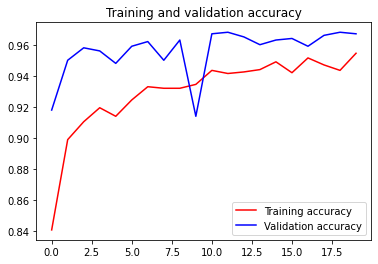

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()